# Lower-star Filtrations

A lower-star filtration on a simplicial complex $X$ is a filtration extended from a function on the vertex set $f: X_0\to \mathbb{R}$.  The lower-star filtration of $X$ at parameter $a$ is the maximal sub-complex of $X$ on the inverse image 
\begin{equation}
f^{-1}((-\infty, a]) \subseteq X_0
\end{equation}

The parameter at which a simplex $(x_0,\dots,x_k)\in X$ appears at is
\begin{equation}
f:(x_0,\dots,x_k) \mapsto \max \{f(x_i) \mid i = 0,\dots,k\}
\end{equation}

## Application to images

A common use of lower-star filtrations is to building filtrations on images using pixel values.

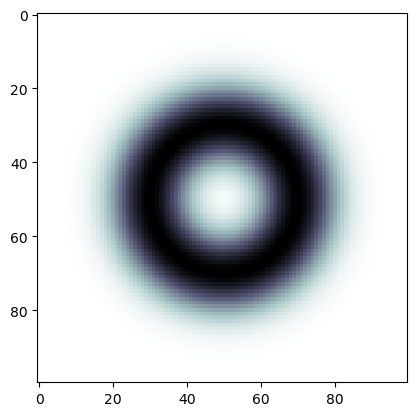

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 100
img = np.empty((n,n))

def rad(i,j, n):
    return np.sqrt((i - n/2)**2 + (j - n/2)**2)

for i in range(n):
    for j in range(n):
#         print(i,j, rad(i,j,n))
        img[i,j] = 1-np.exp(-(rad(i,j,n) - 20)**2/100)
        
plt.imshow(img, cmap='bone')
plt.show()

This image is a function on the square discretized into pixels.  We can build a simplicial complex which triangulates the square with vertices (0-simplices) identified with the pixels using the Freudenthal triangulation.

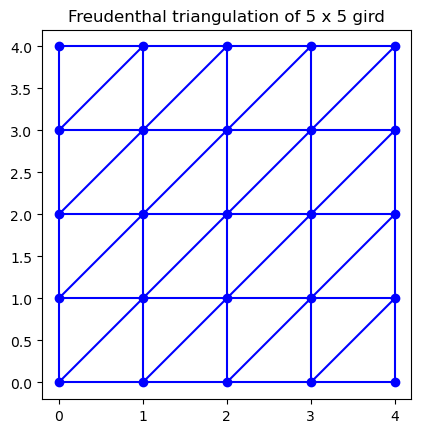

In [2]:
import bats

m = 5
X = bats.Freudenthal(m, m)
xx, yy = np.meshgrid(np.arange(m), np.arange(m))
xx = xx.flatten()
yy = yy.flatten()

fig, ax = plt.subplots()

# scatter vertices
ax.scatter(xx, yy, c='b')
# plot edges
for e in X.get_simplices(1):
    ax.plot(xx[e], yy[e], c='b')

ax.set_title("Freudenthal triangulation of {0} x {0} gird".format(m))
ax.set_aspect('equal')
plt.show(fig)

To compute the lower-star filtration, we can use `bats.lower_star_filtration`, which returns the filtration value for each simplex as well as a map back to the largest value vertex in the simplex.

In [3]:
X = bats.Freudenthal(n, n)
vals, imap = bats.lower_star_filtration(X, img.flatten()) # computes filtration parameter to 
F = bats.Filtration(X, vals)

We can visualize the filtration on vertices:

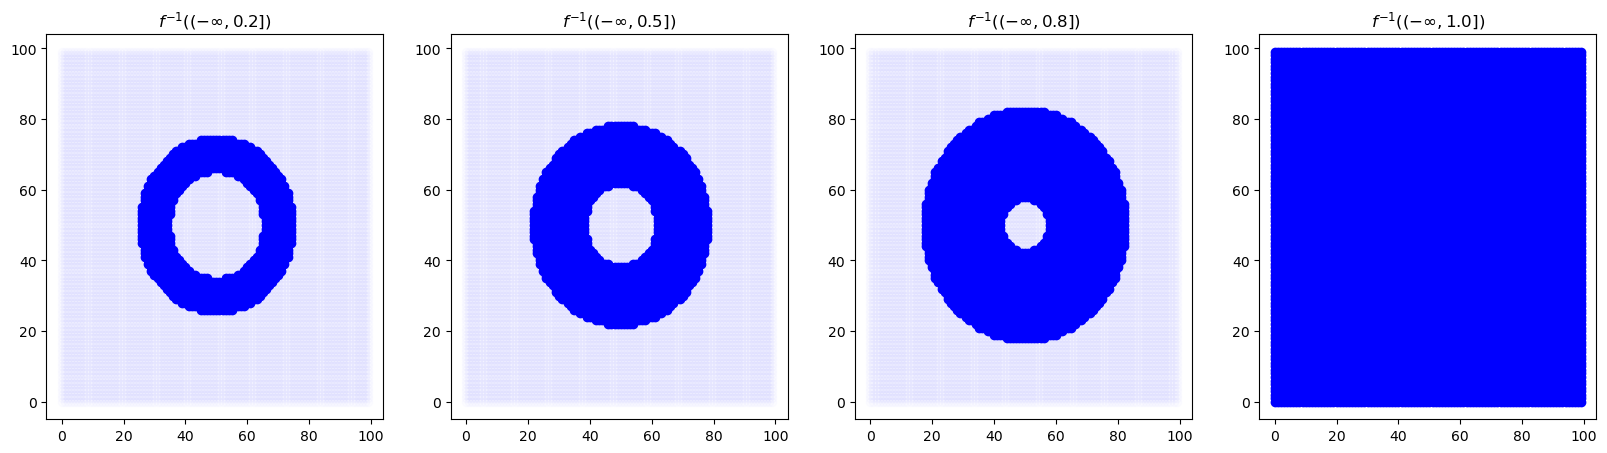

In [4]:
def show_sublevel(ax, F, alpha, xx, yy):
    """
    visualize the sublevelset (-inf, alpha]
    """
    Xa = F.sublevelset(alpha)
    ax.scatter(xx, yy, color=(0,0,1,0.01))
    
    # 0-simplices
    X0 = Xa.get_simplices(0)
    ax.scatter(xx[X0], yy[X0], color=(0,0,1,1))
    
    ax.set_title(r"$f^{{-1}}((-\infty, {}])$".format(alpha))

alphas = [0.2, 0.5, 0.8, 1.0]
fig, axs = plt.subplots(1, len(alphas), figsize = (5*len(alphas), 5))

xx, yy = np.meshgrid(np.arange(n), np.arange(n))
xx = xx.flatten()
yy = yy.flatten()

for ax, alpha in zip(axs, alphas):
    show_sublevel(ax, F, alpha, xx, yy)
    
plt.show(fig)

And compute persistent homology

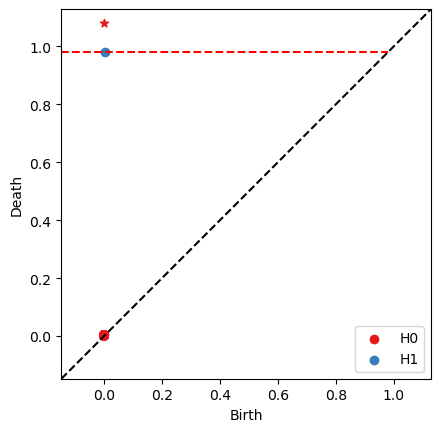

In [5]:
RF = bats.reduce(F, bats.F2())
ps = RF.persistence_pairs(0) + RF.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

We see a prominent $H_1$ pair corresponding to the annulus

In [6]:
for p in ps:
    if p.length() > 0.5:
        print(p)

0 : (0,inf) <3050,-1>
1 : (0.00378158,0.981684) <20537,10001>


## Visualization

### Homology Generators

You can extract homology generators from a `ReducedFilteredChainComplex`, the output of `bats.reduce`.

Let's look at a new image with several long bars in $H_0$ and $H_1$

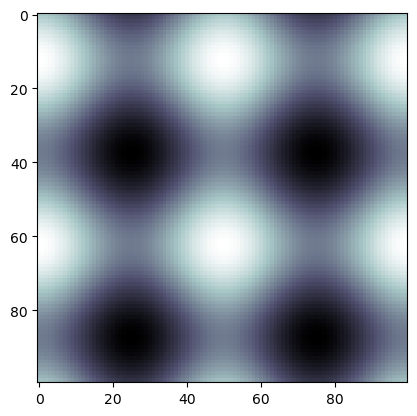

In [7]:
img2 = np.empty((n,n))
for i in range(n):
    for j in range(n):
        img2[i,j] = np.sin(4*np.pi*i/n) + np.cos(4*np.pi*j/n)
        
plt.imshow(img2, cmap='bone')
plt.show()

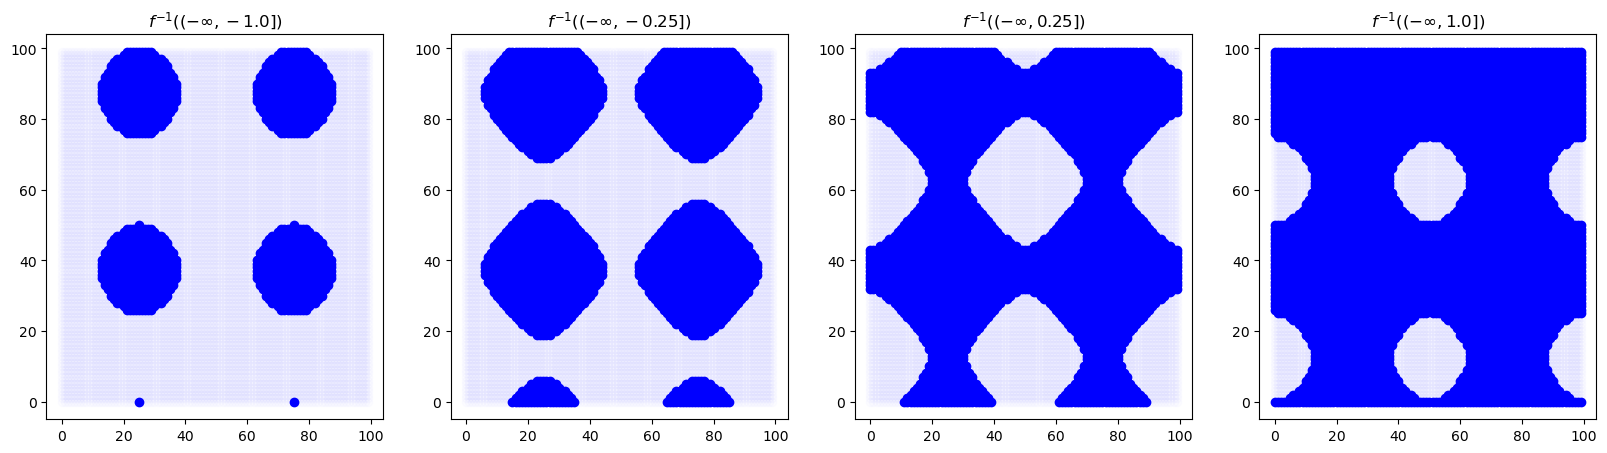

In [8]:
vals, imap = bats.lower_star_filtration(X, img2.flatten()) # computes filtration parameter to 
F = bats.Filtration(X, vals)

alphas = [-1.0, -0.25, 0.25, 1.0]
fig, axs = plt.subplots(1, len(alphas), figsize = (5*len(alphas), 5))

xx, yy = np.meshgrid(np.arange(n), np.arange(n))
xx = xx.flatten()
yy = yy.flatten()

for ax, alpha in zip(axs, alphas):
    show_sublevel(ax, F, alpha, xx, yy)
    
plt.show(fig)

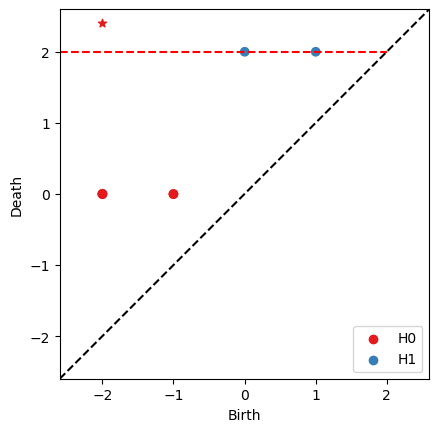

In [9]:
RF = bats.reduce(F, bats.F2())
ps = RF.persistence_pairs(0) + RF.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

In [10]:
nzps = [p for p in ps if p.length() > 0]
for p in nzps:
    print(p)

0 : (-1.99803,inf) <3725,-1>
0 : (-1.99803,0.00197327) <3775,10979>
0 : (-1.99803,-0.00197327) <8825,18948>
0 : (-1.99803,-0.00197327) <8875,19098>
0 : (-1,-0.00197327) <51,4048>
0 : (-1,-0.00197327) <151,4198>
1 : (0.00197327,1.99803) <26177,12575>
1 : (1,1.99803) <203,2675>


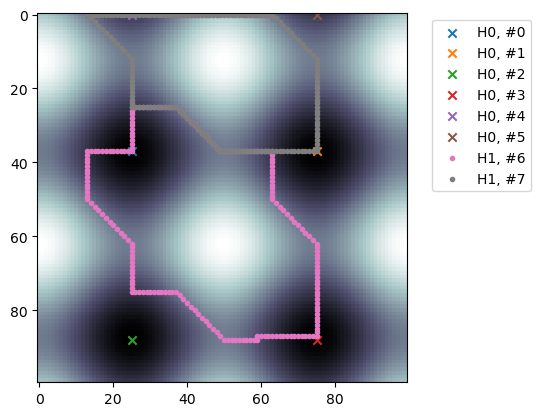

In [11]:
# visualization of representatives
plt.imshow(img2, origin='upper', cmap='bone')

for pi, p in enumerate(nzps):
    c = RF.representative(p, False)
    d = p.dim()
    supp = np.unique([X.get_simplex(d, i) for i in c.nzinds()])


    xx = supp % n
    yy = supp // n
    if p.dim() == 0:
        marker='x'
    else:
        marker='.'
    plt.scatter(xx[:],yy[:],marker=marker,label="H{}, #{}".format(d, pi))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Critical Simplices

Critical simplices are the simplices whose addition to the filtration causes a homology class to be born or killed.  

Lower-star filtrations provide an inverse map back to the pixel which gave the critical simplex its filtration value.  This is the `imap` which we computed in `vals, imap = bats.lower_star_filtration(...)`

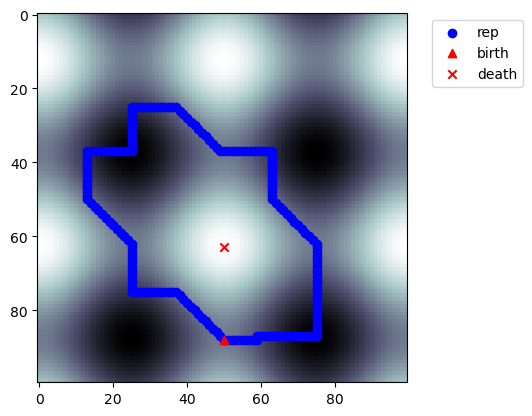

In [12]:
p = nzps[-2]
d = p.dim()
plt.imshow(img2, cmap='bone')

# representative
c = RF.representative(p)
supp = np.unique([X.get_simplex(d, i) for i in c.nzinds()])

xx = supp % n
yy = supp // n
plt.scatter(xx[:],yy[:],c='b',label="rep")

bskel = np.array([imap[d][p.birth_ind()]])
xx = bskel % n
yy = bskel // n
plt.scatter(xx[:],yy[:],  c='r', marker='^', label="birth")
if p.death_ind() != 18446744073709551615:
    dskel = np.array([imap[d+1][p.death_ind()]])
    xx = dskel % n
    yy = dskel // n
    plt.scatter(xx[:],yy[:], c='r', marker='x', label="death")
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Non-Uniqueness of Generators

Homology generators are not unique, as we can add any element of $\mathop{img} \partial_{k+1}$ to a representative of $H_k$ and stay in the homology class.  However, the critical simplices will be the same.

This behavior can be seen using different reduction options in BATS.

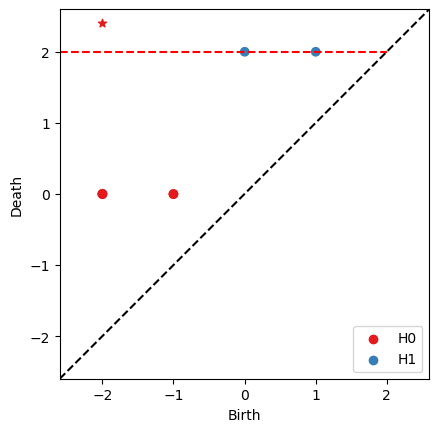

In [13]:
RF = bats.reduce(F, bats.F2(), bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
ps = RF.persistence_pairs(0) + RF.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

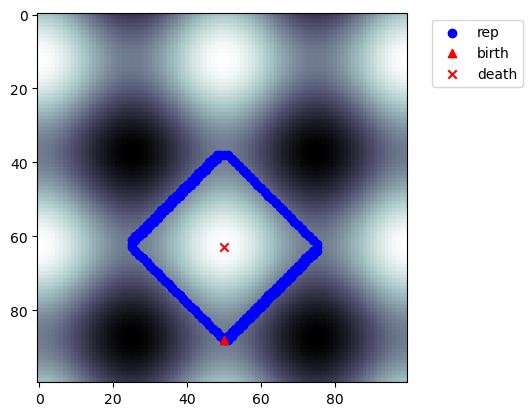

In [14]:
nzps = [p for p in ps if p.length() > 0]

p = nzps[-2]
d = p.dim()
plt.imshow(img2, cmap='bone')

# representative
c = RF.representative(p)
supp = np.unique([X.get_simplex(d, i) for i in c.nzinds()])

xx = supp % n
yy = supp // n
plt.scatter(xx[:],yy[:],c='b',label="rep")

bskel = np.array([imap[d][p.birth_ind()]])
xx = bskel % n
yy = bskel // n
plt.scatter(xx[:],yy[:],  c='r', marker='^', label="birth")
if p.death_ind() != 18446744073709551615:
    dskel = np.array([imap[d+1][p.death_ind()]])
    xx = dskel % n
    yy = dskel // n
    plt.scatter(xx[:],yy[:], c='r', marker='x', label="death")
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Cubical Complexes

Lower-star filtrations can be applied to cubical complexes as well (the inverse map is not computed)

In [15]:
X = bats.Cube(n,n)
vals = bats.lower_star_filtration(X, img)
F = bats.Filtration(X, vals)

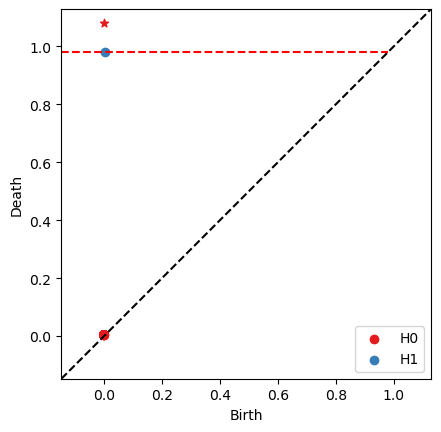

In [16]:
RF = bats.reduce(F, bats.F2())
ps = RF.persistence_pairs(0) + RF.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

In [17]:
for p in ps:
    if p.length() > 0.5:
        print(p)

0 : (0,inf) <3050,-1>
1 : (0.00378158,0.981684) <13747,5000>
